In [205]:
import numpy as np
import cv2
from scipy.fft import fft
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os
import time
import pandas as pd
import gc

In [2]:
video_path = r"C:\Users\cpesther\Desktop\New CBF Videos\Plate2_Culture1_Pre_0001.avi"
sampling_rate = 60
power_threshold = 5

In [3]:
# Open video
print(f'Loading video {video_path}...')
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError(f'ERROR: Cannot open video {video_path}')

# Calculate some details
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
num_pixels = frame_width * frame_height

# Region of interest (ROI): full frame (can be modified for manual selection)
roi_x = np.arange(frame_width)
roi_y = np.arange(frame_height)

# Reset cap read, just to be safe
print('Converting to grayscale...')
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Preallocate array for grayscale frames
grayscale_frames = np.zeros((num_frames, frame_height, frame_width), dtype=np.uint8)

# Read and convert frames
for i in range(num_frames):
    ret, frame = cap.read()
    if not ret:
        break
    # Convert frame to grayscale using OpenCV
    grayscale_frames[i] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

grayscale_frames_float = grayscale_frames.astype(np.float32)  # convert to float

# This script is memory intensive; you're gonna see a lot of deletes so 
# that we can squeeze every bit of memory out of the maching that we can
del cap
del grayscale_frames
gc.collect()  # also force garbage collection

Loading video C:\Users\cpesther\Desktop\New CBF Videos\Plate2_Culture1_Pre_0001.avi...


In [159]:
# Preallocate arrays for results
print('Allocating memory...')
fft_length = num_frames // 2 + 1  # keep only first half b/c second half is redundant
psd_map = np.zeros((frame_height, frame_width, fft_length), dtype=np.float16)  # float16 less precise, but half the size
max_psd_map = np.zeros((frame_height, frame_width), dtype=np.float32)

Allocating memory...


In [170]:
# Run the actual iteration over each time series provided
print('Performing FFT calculations...')

start = time.time()
for row in range(frame_height):  # y-coordinate

    # Put our progress bar here
    print(f'Processing {row * frame_width} of {frame_height * frame_width} pixels...', end='\r')
    
    for column in range(frame_width):  # x-coordinate
        
        # Calculate the FFT
        pixel_ts = grayscale_frames_float[:, row, column]  # pull the time series
        norm_pixel_ts = pixel_ts - np.mean(pixel_ts)       # normalize it to its mean
        fft_result = np.fft.fft(norm_pixel_ts) 
        fft_result_trimmed = fft_result[:fft_length]       # take only first half

        # Calculate the PSD
        psd = (1 / (num_frames * sampling_rate)) * np.abs(fft_result_trimmed) ** 2
        psd[1:-1] *= 2  # correct amplitude for 1-sided PSD
        psd[:15] = 0    # remove very low frequencies

        # Save the data 
        psd_map[row, column, :] = psd
        max_psd_map[row, column] = np.max(psd)

print(f'Finished FFT analysis in {round(time.time() - start, 2)} seconds')
print(f'est total {((time.time() - start) / (frame_height * frame_width)) * num_pixels}')

Performing FFT calculations...
Finished FFT analysis in 2.07 seconds
est total 115.25767578125001


In [197]:
# Now that we're outside of the loop, we can do some more calculations
# First, we'll calculate the maximum power of each pixel
print('Performing final calculations...')

# And calculate the frequency vector so we can plot the PSD nicely
frequency_vector = np.linspace(0, sampling_rate / 2, num_frames // 2 + 1)

# Average all the PSDs together to get one PSD representative of the whole video
avg_psd = np.mean(psd_map, axis=(0, 1))

# Calculate the percent ciliation by counting how many are above a certain
# power threshold (fraction of functional ciliated area). 
flat_max_psds = max_psd_map.flatten()
FFCA = np.sum(flat_max_psds > power_threshold) / flat_max_psds.size
FFCA_map = (max_psd_map >= power_threshold).astype(int)

Performing final calculations...


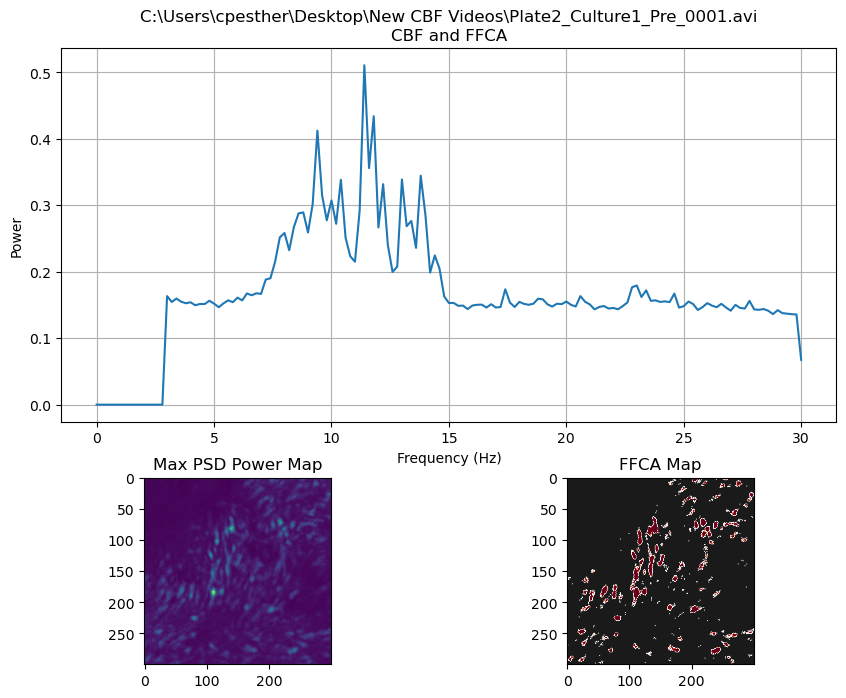

In [209]:
# Plot mean PSD periodogram
# Create figure
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])  # 2 rows, 2 columns

ax_top = fig.add_subplot(gs[0, :])
ax_top.plot(frequency_vector, avg_psd)
ax_top.set_title("Top long plot")
ax_top.grid(True)
ax_top.set_title(f'{video_path}\nCBF and FFCA')
ax_top.set_xlabel('Frequency (Hz)')
ax_top.set_ylabel('Power')

ax_bottom1 = fig.add_subplot(gs[1, 0])
ax_bottom1.set_title('Max PSD Power Map')
ax_bottom1.imshow(max_psd_map)

ax_bottom2 = fig.add_subplot(gs[1, 1])
ax_bottom2.set_title('FFCA Map')
ax_bottom2.imshow(FFCA_map, cmap='RdGy_r')



In [ ]:
from scipy.io import savemat
test_series = clean_time_series[:10]
mat_dict = {
    'test_series': clean_time_series[:10]
}

# Save to MATLAB .mat file
savemat('gtest_series.mat', mat_dict)

In [ ]:
# First, define a function that iterates over a list of time series 
# and calculates the FFT. We can now use this function on multiple 
# processes to speed up this iterative process.
def perform_FFT(chunk_time_series, num_frames, sampling_rate, print_status=False):
    
    """
    This function performs a FFT on a list of pixel time series. 
    We have defined it as its own function so that we can break the 
    total number of pixels into multiple chunks and multiprocess this
    process. All chunks get put back together at the end.
    """

   
    
    # Preallocate lists for results
    fft_length = num_frames // 2 + 1  # keep only first half b/c second half is redundant
    num_pixels = len(chunk_time_series)

    # Preallocate arrays for results
    pixel_psds = np.empty((num_pixels, fft_length), dtype=np.float32)
    max_pixel_psds = np.empty(num_pixels, dtype=np.float32)

    # Run the actual iteration over each time series provided
    for index, intensity_time_series in enumerate(chunk_time_series):

        if print_status:
            print(f'Processing {index} of {num_pixels} pixels...', end='\r')
        
        # Calculate FFT and trim the result to only the first half
        fft_result = fft(intensity_time_series)[:fft_length] 
    
        # Calculate PSD values
        psd = (1 / (num_frames * sampling_rate)) * np.abs(fft_result) ** 2  # calculate PSD
        psd[1:-1] *= 2  # double all values (except first and last) b/c one-sided PSD
        psd[:15] = 0    # remove very low frequency noise
        
        # Store values into list
        pixel_psds[index, :] = psd
        max_pixel_psds[index] = np.max(psd)

    # When finished, return the lists
    return pixel_psds, max_pixel_psds
